# Use HTA to compare traces from pytorch profiler
1. Create 2 directories one for control and one for test
2. Download the respective traces into those directories
3. Modify the GLOBALS, TRACE_DIR_CTRL and TRACE_DIR_TEST to point to the dirs.

In [13]:
from hta.trace_analysis import TraceAnalysis
import pandas as pd
import plotly.express as px
from IPython.display import Image


TIME_COL = 'time (%)'
SUM_COL = 'time (ms)'

def create_comms_df(kernel_metrics_df, tag):
    tot_time = kernel_metrics_df['sum (ns)'].sum()
    kernel_metrics_df[TIME_COL] =  kernel_metrics_df['sum (ns)'].apply(lambda x : round((x / tot_time) * 100)) 
    comms_df = kernel_metrics_df.query("kernel_type == 'COMMUNICATION'").rename(columns={'sum (ns)': SUM_COL})
    comms_df = comms_df[['name', TIME_COL, SUM_COL]]
    comms_df['collective'] = comms_df['name'].apply(lambda x : x[0:x.find('(')])
    comms_df['experiment'] = tag
    comms_df[SUM_COL] = comms_df[SUM_COL].apply(lambda x : round(x / 1000000, 1))
    return comms_df

def merge_comms_df(comms_df_a, comms_df_b):
    consoli_comms_df = pd.concat([comms_df_a, comms_df_b],  ignore_index=True)
    consoli_comms_df = consoli_comms_df[consoli_comms_df[TIME_COL] > 0]
    return consoli_comms_df

def create_per_collective_bkdown_plot(consoli_comms_df, title = "Control Vs Test"):
    fig =px.bar(consoli_comms_df, x='experiment', color='collective', y=SUM_COL)
    #            text_auto=True)
    fig.update_layout(title=title, title_x=0.5)

    fig.update_traces(textfont_size=12, textposition="outside", cliponaxis=False,
                      marker=dict(line=dict(color='#000000', width=2)))
    fig.show()
    # img_bytes = fig.to_image(format="png")
    #Image(img_bytes)

In [4]:
TRACE_DIR_CTRL = "~/trace_dir/mtron_2d"
CTRL_TAG = "FS-Megatron"
TRACE_DIR_TEST = "~/trace_dir/tp_2d"
TEST_TAG = "PTD-TP"
include_memory_kernels = False
PLOT_TITLE = "FS-Megatron Vs TP"

2022-12-21 17:18:33,029 - hta - trace.py:L368 - INFO - /Users/gnadathur/trace_dir/mtron_2d
2022-12-21 17:18:34,730 - hta - trace_file.py:L95 - INFO - Rank to trace file map:
{0: '/Users/gnadathur/trace_dir/mtron_2d/trace.json'}
2022-12-21 17:18:34,732 - hta - trace.py:L495 - INFO - ranks=[0]
2022-12-21 17:18:41,326 - hta - trace.py:L113 - INFO - Parsed /Users/gnadathur/trace_dir/mtron_2d/trace.json time = 1.29 seconds mem = 325.32 MB
2022-12-21 17:18:47,432 - hta - trace.py:L619 - WARNING - There is only one iteration in the trace. The analysis result may not be accurate.


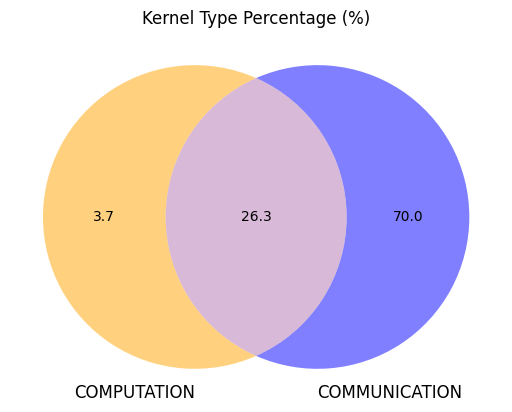

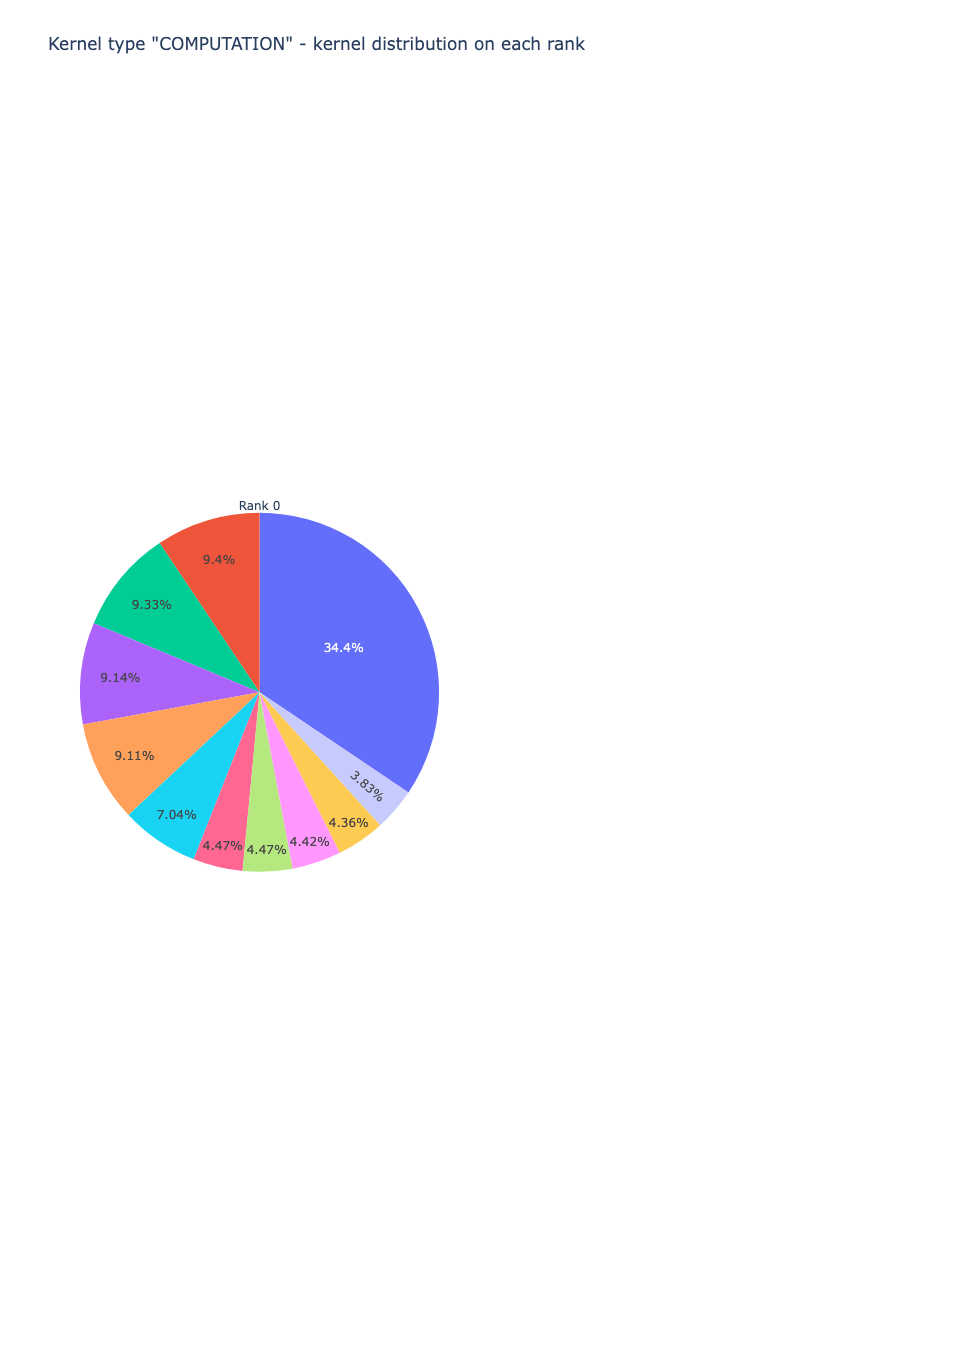

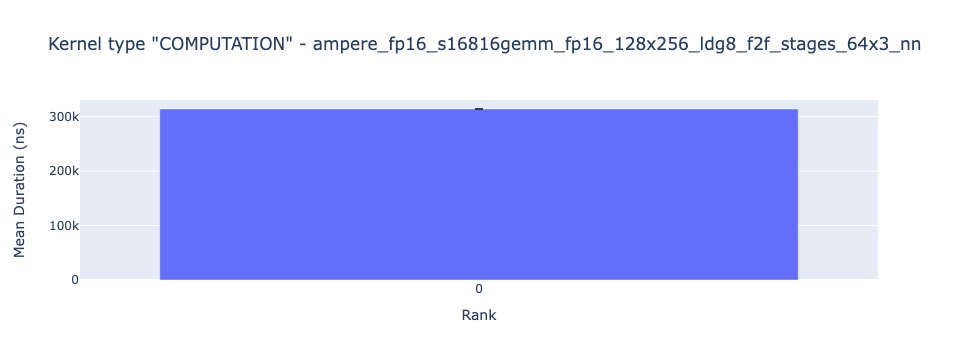

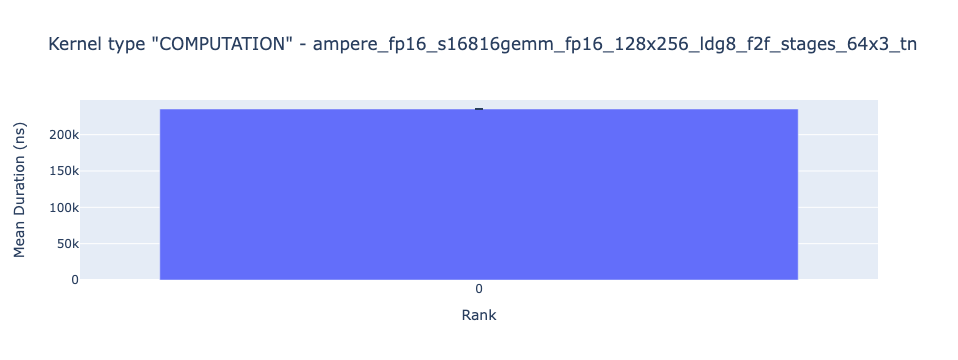

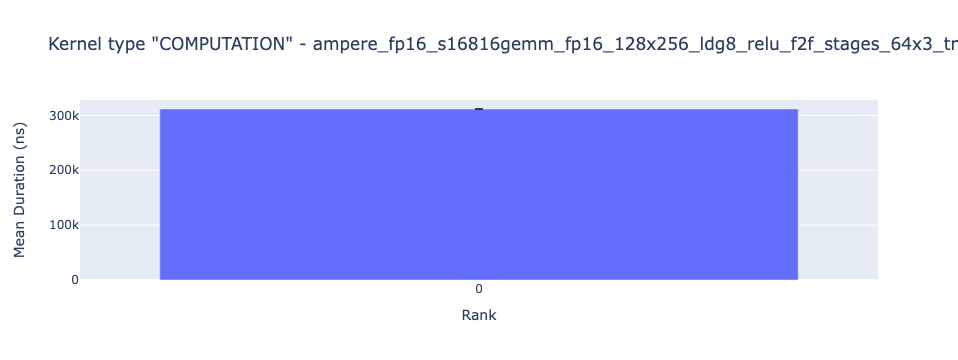

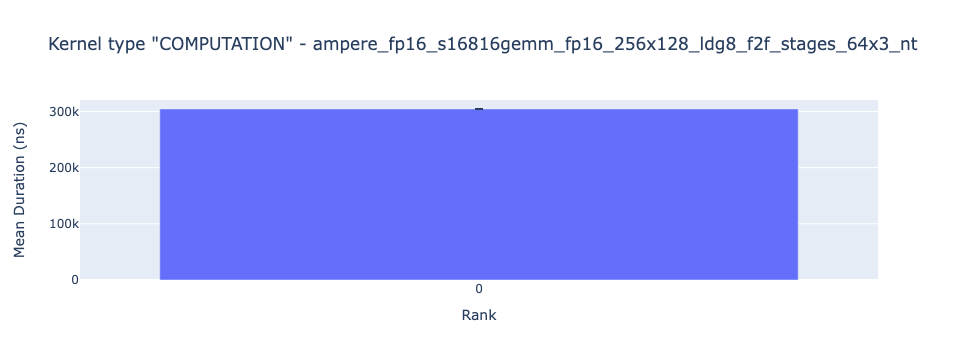

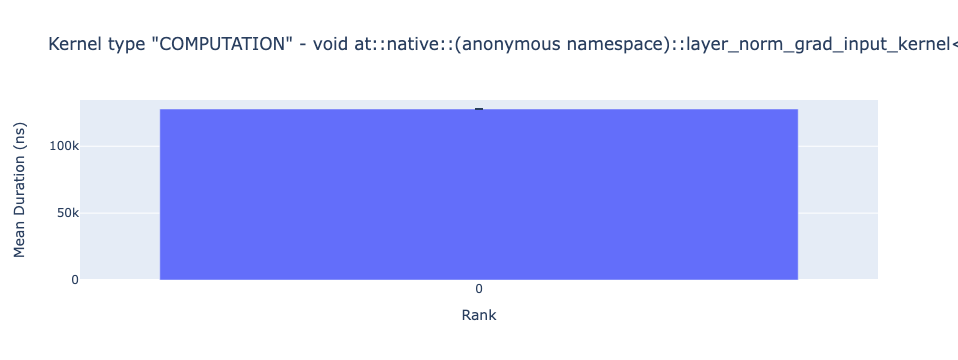

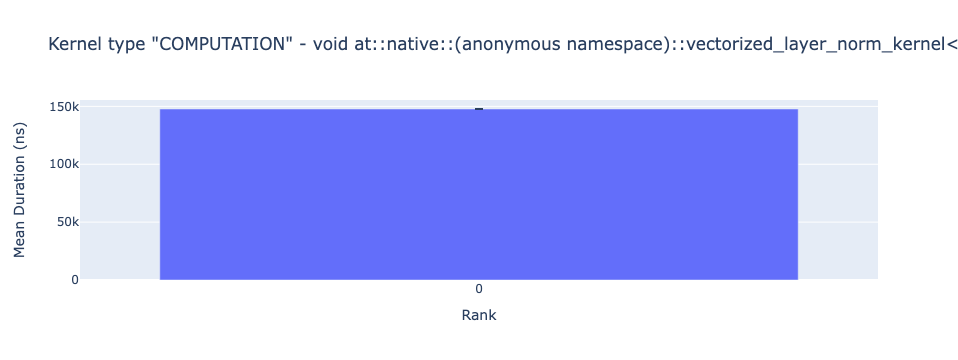

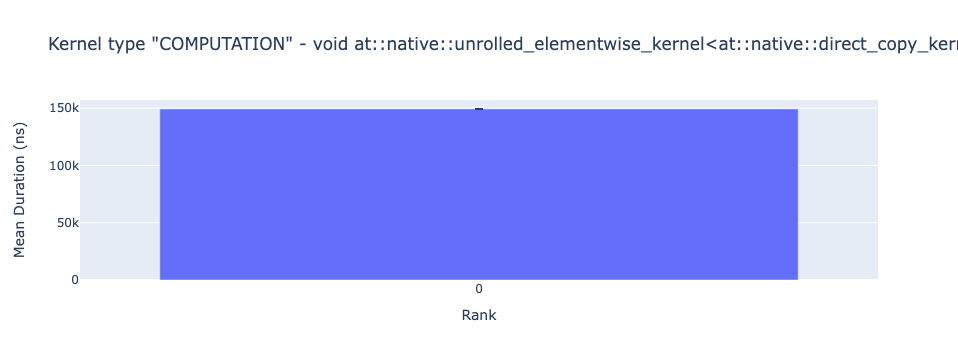

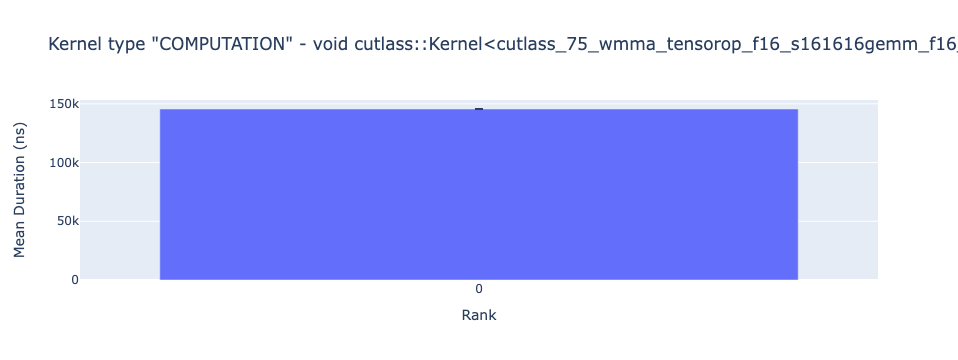

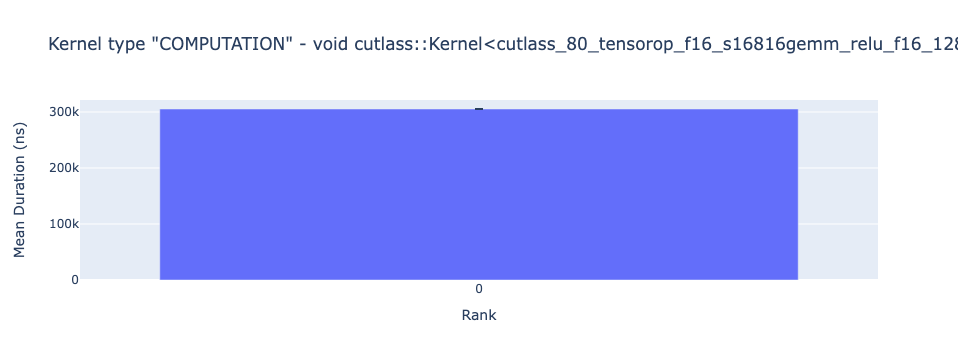

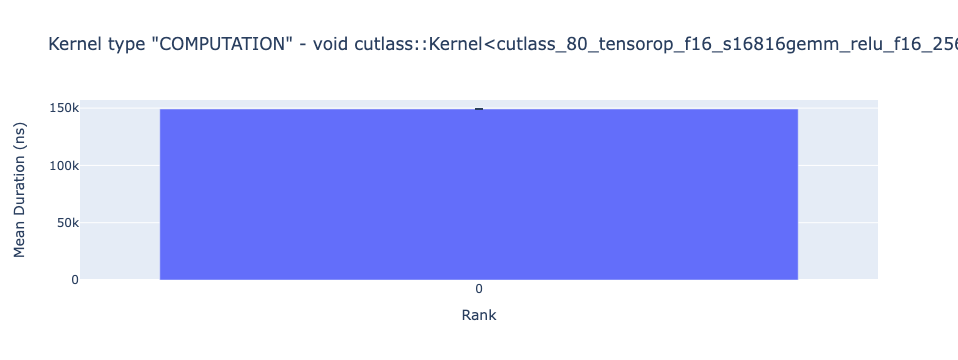

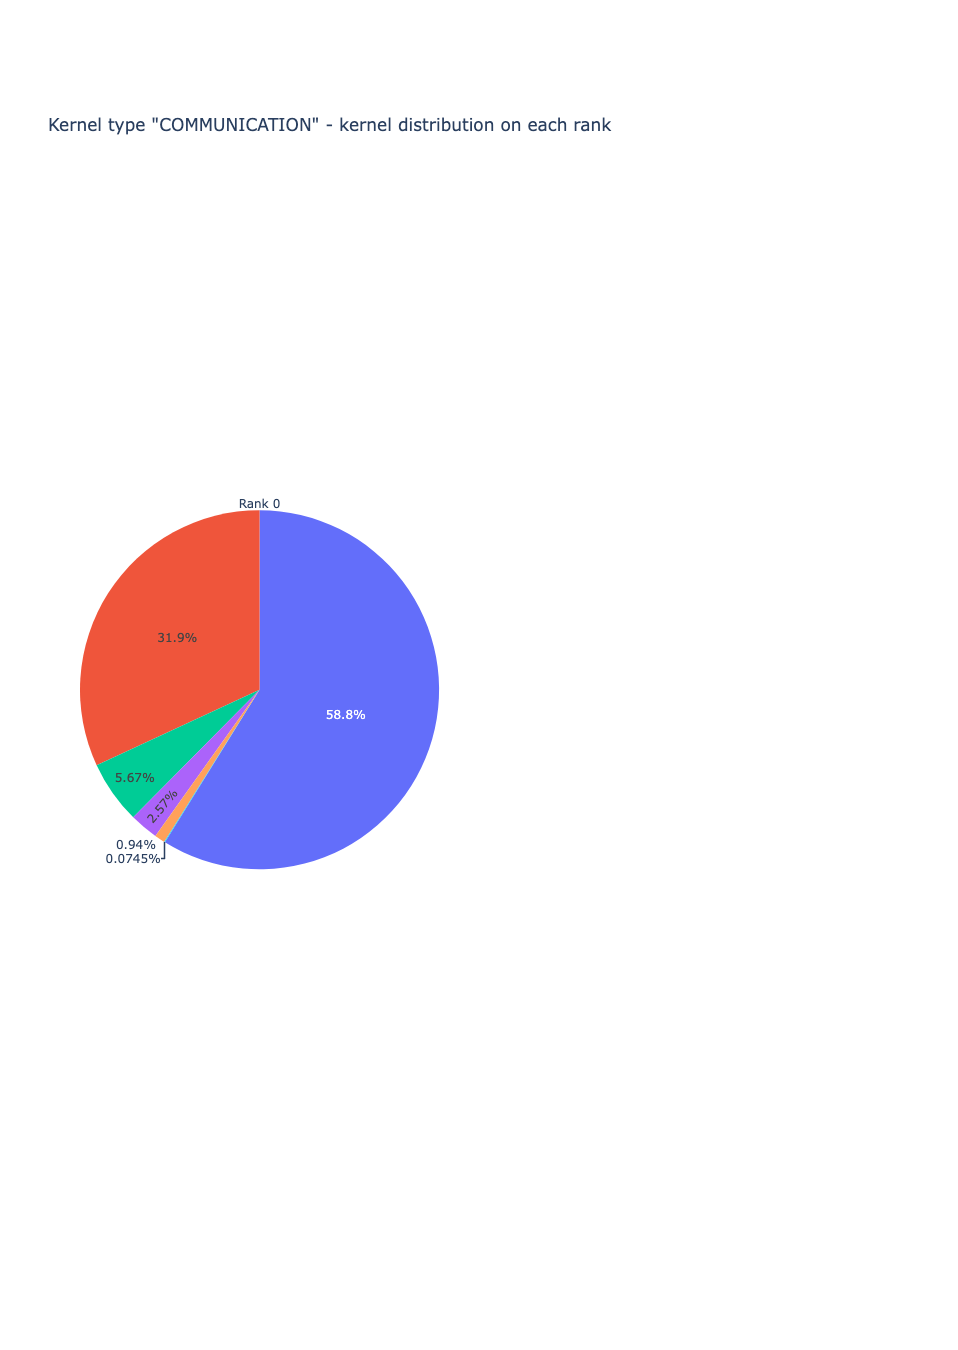

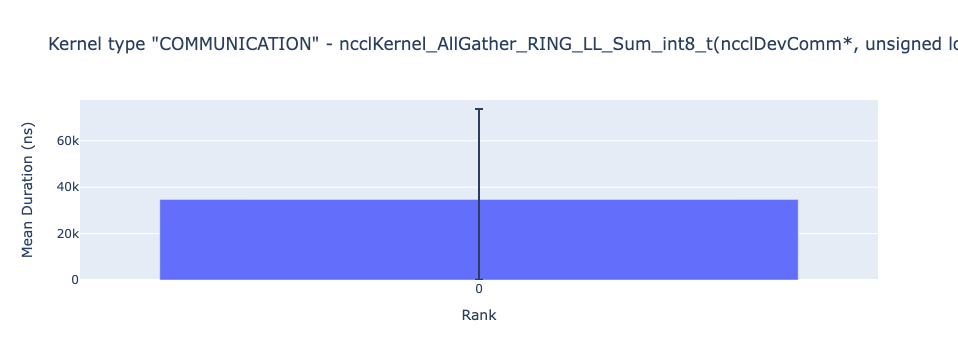

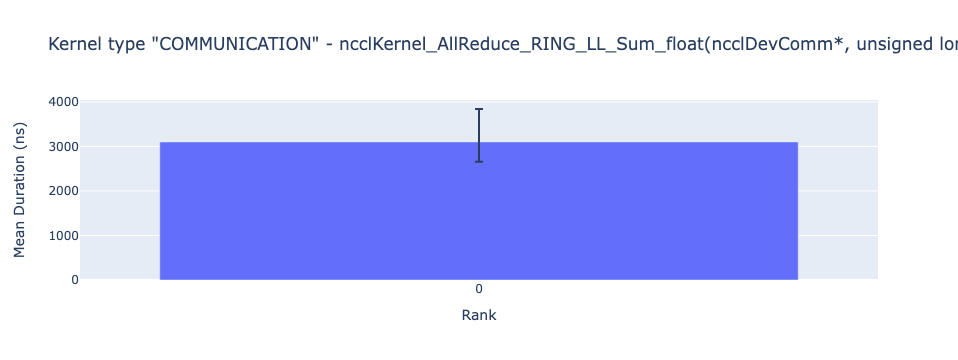

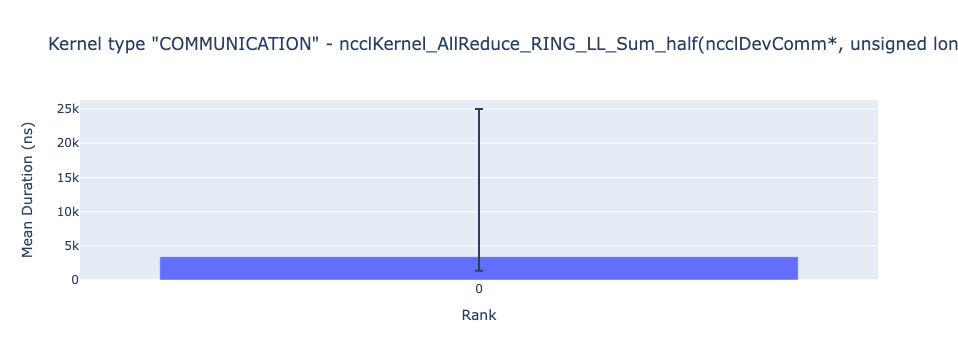

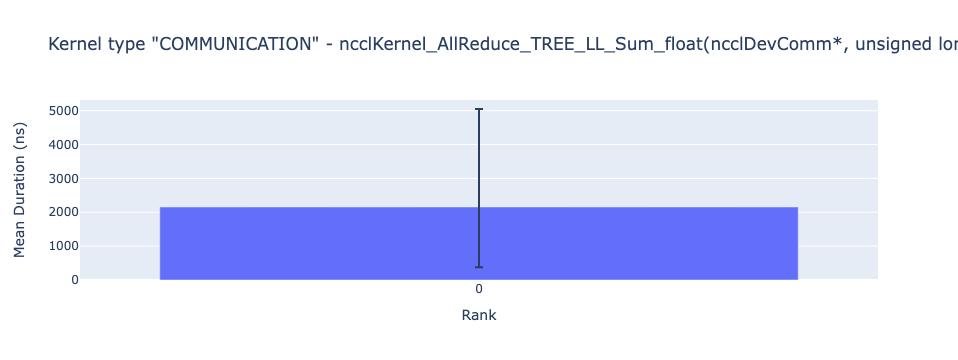

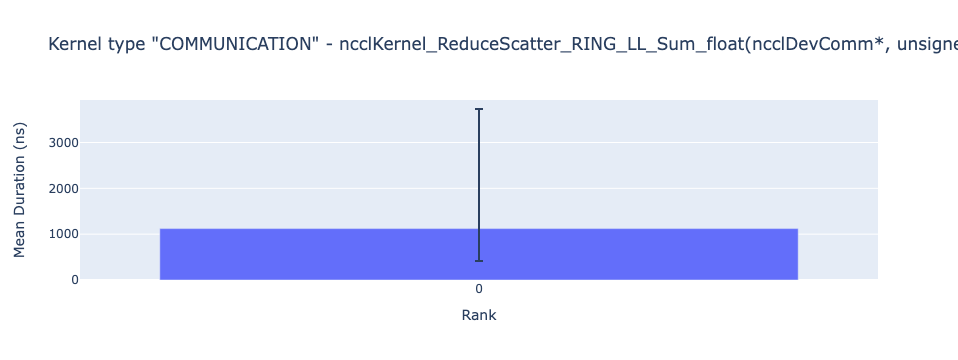

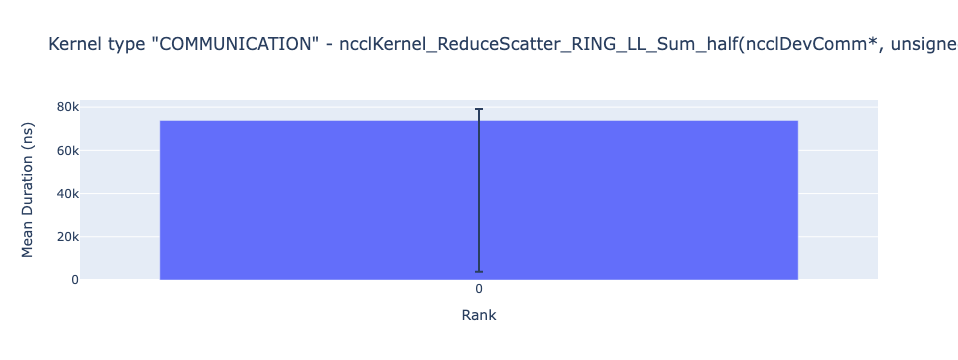

In [5]:
analyzer_ctrl = TraceAnalysis(trace_dir = TRACE_DIR_CTRL)
kernel_type_metrics_df_ctrl, kernel_metrics_df_ctrl = analyzer_ctrl.get_gpu_kernel_breakdown( 
                                             num_kernels=10, 
                                             include_memory_kernels=include_memory_kernels, 
                                             image_renderer="jupyterlab")
comms_df_ctrl = create_comms_df(kernel_metrics_df_ctrl, CTRL_TAG)

2022-12-21 17:18:52,725 - hta - trace.py:L368 - INFO - /Users/gnadathur/trace_dir/tp_2d
2022-12-21 17:18:58,603 - hta - trace_file.py:L95 - INFO - Rank to trace file map:
{0: '/Users/gnadathur/trace_dir/tp_2d/trace.json'}
2022-12-21 17:18:58,604 - hta - trace.py:L495 - INFO - ranks=[0]
2022-12-21 17:19:24,164 - hta - trace.py:L113 - INFO - Parsed /Users/gnadathur/trace_dir/tp_2d/trace.json time = 4.69 seconds mem = 1242.32 MB
2022-12-21 17:19:54,443 - hta - trace.py:L619 - WARNING - There is only one iteration in the trace. The analysis result may not be accurate.


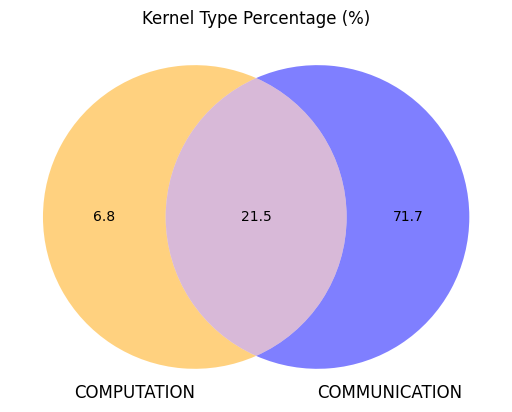

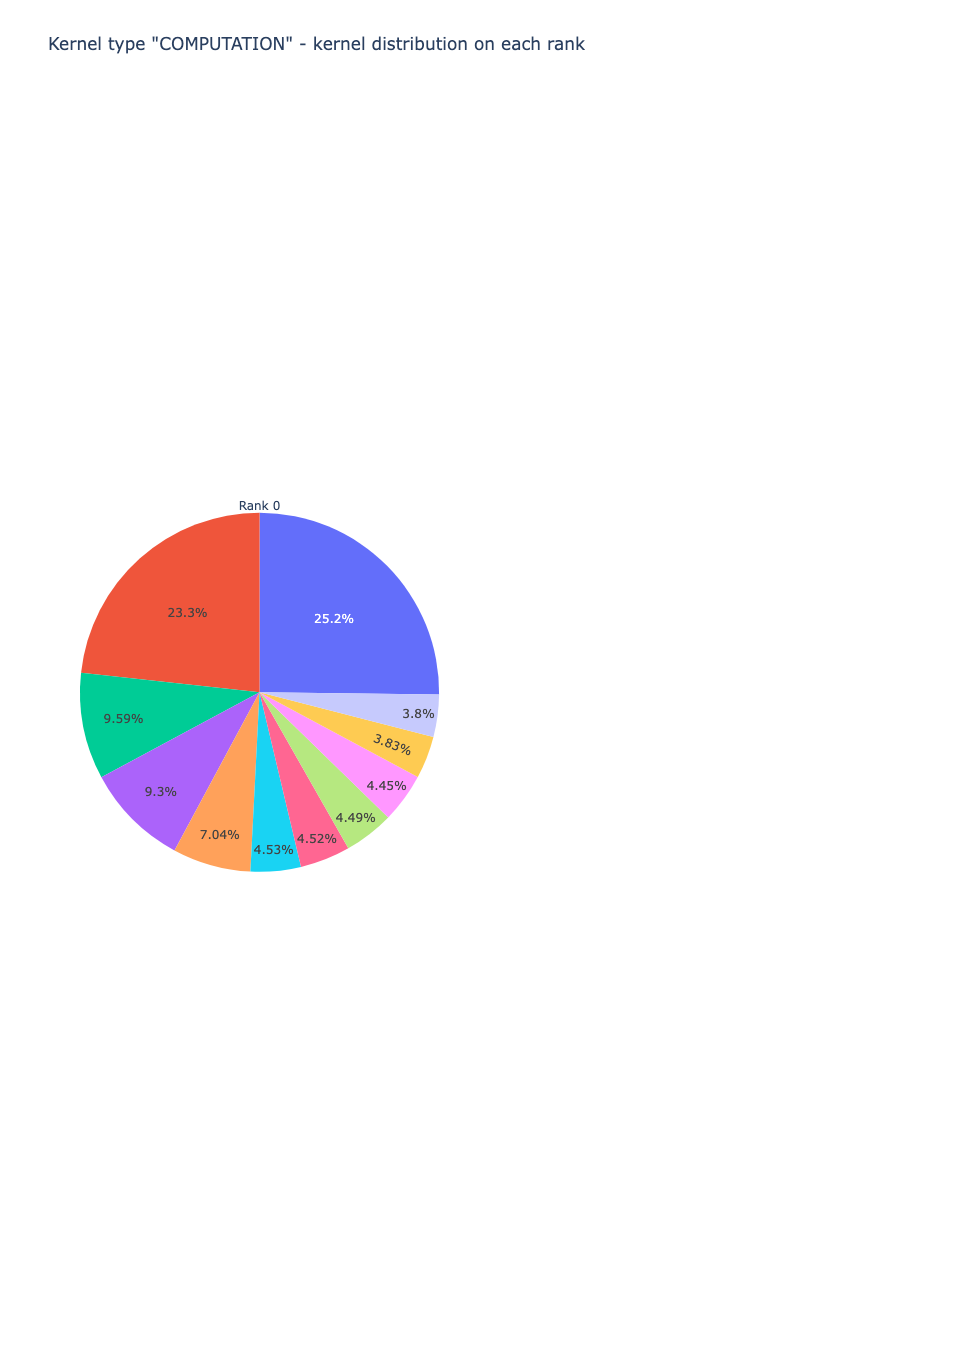

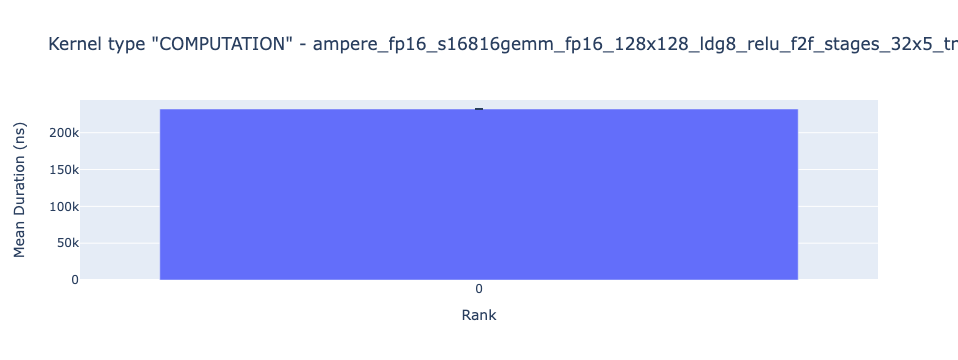

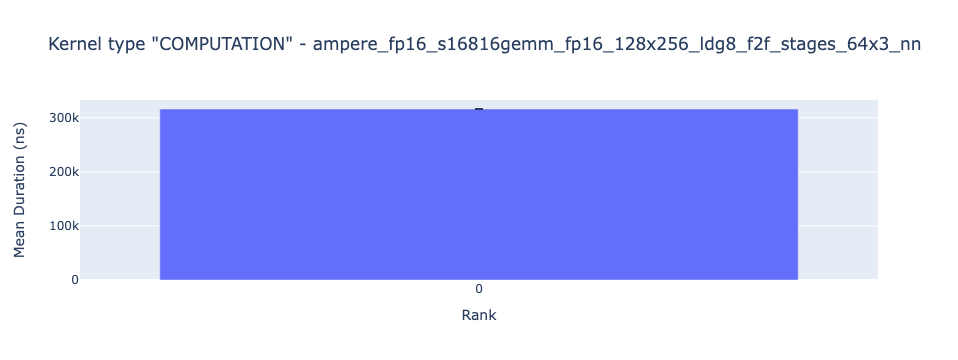

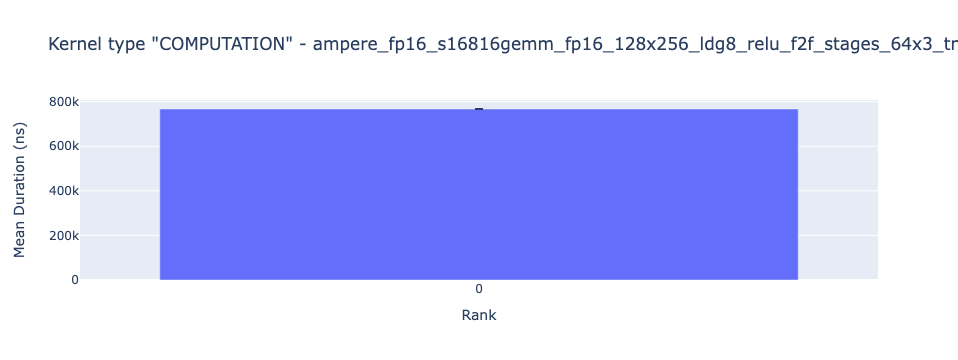

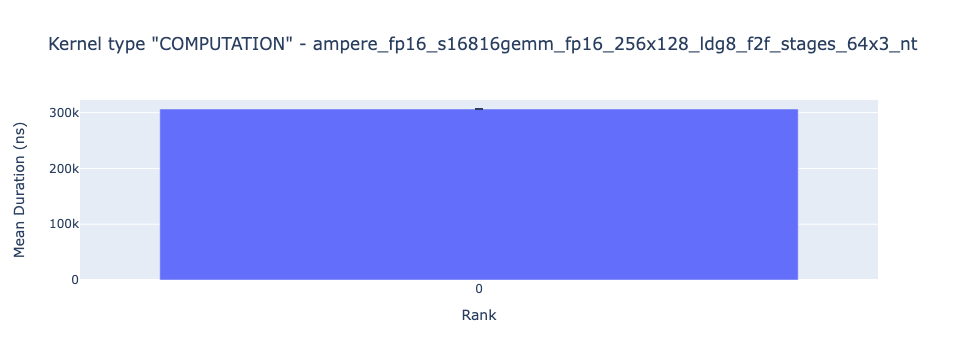

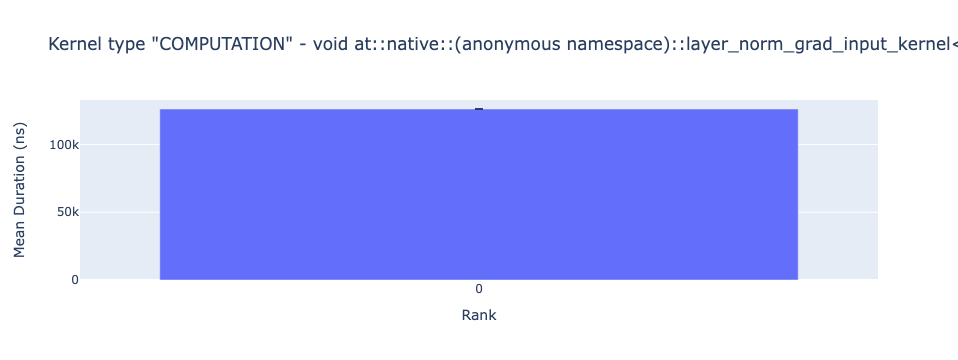

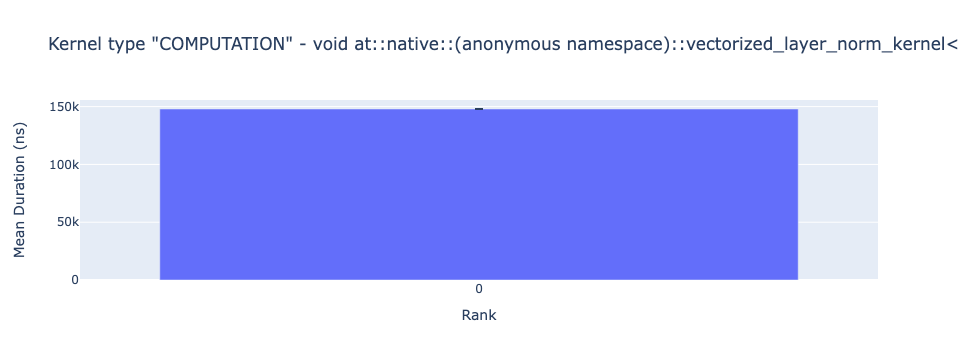

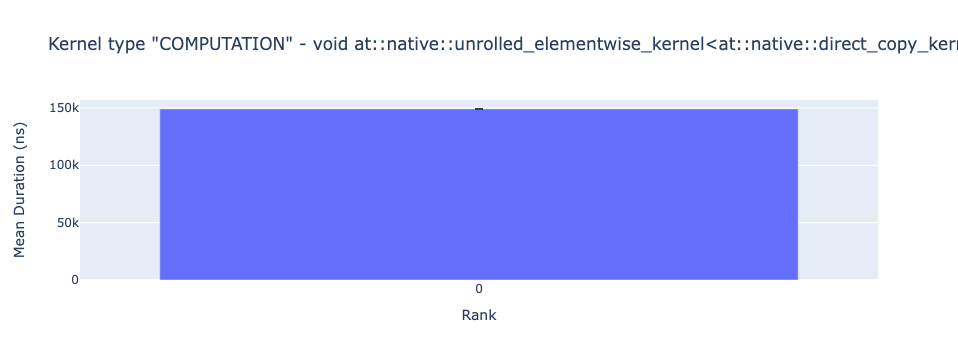

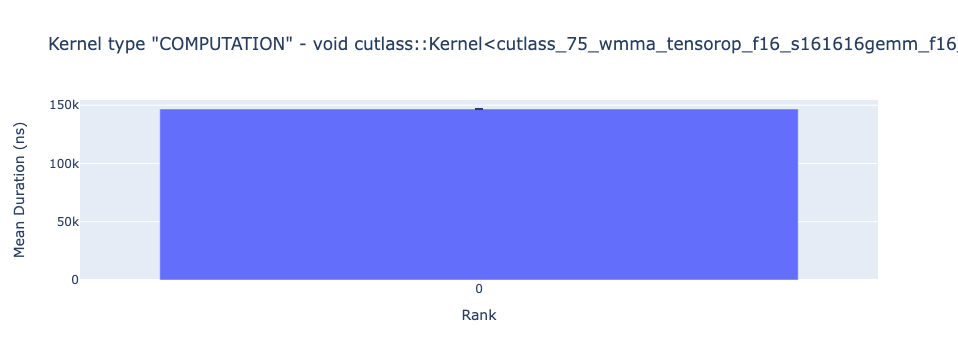

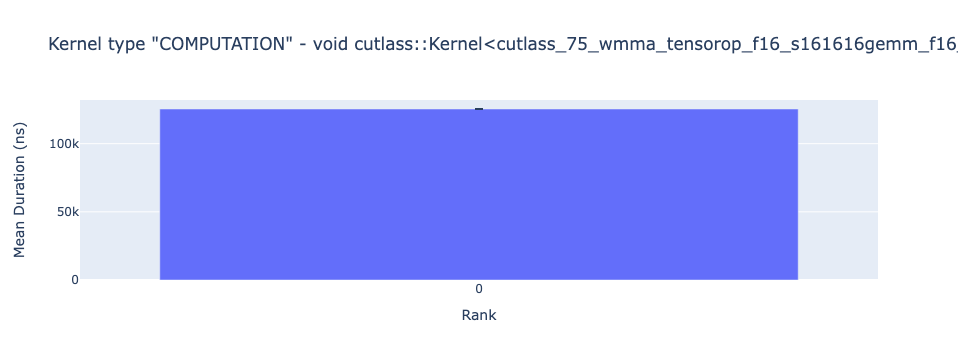

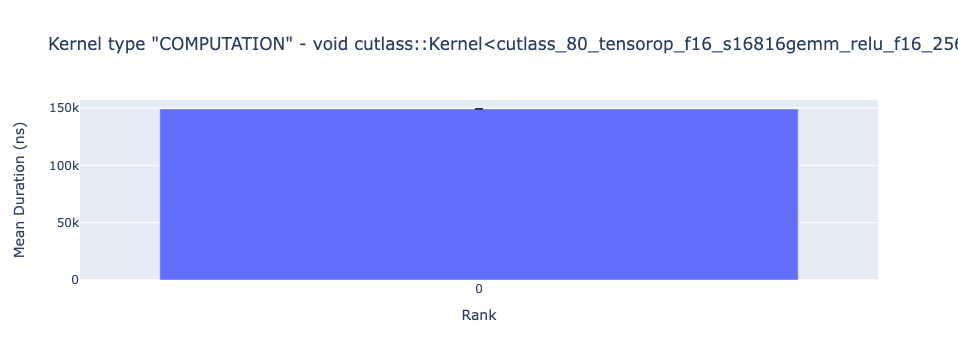

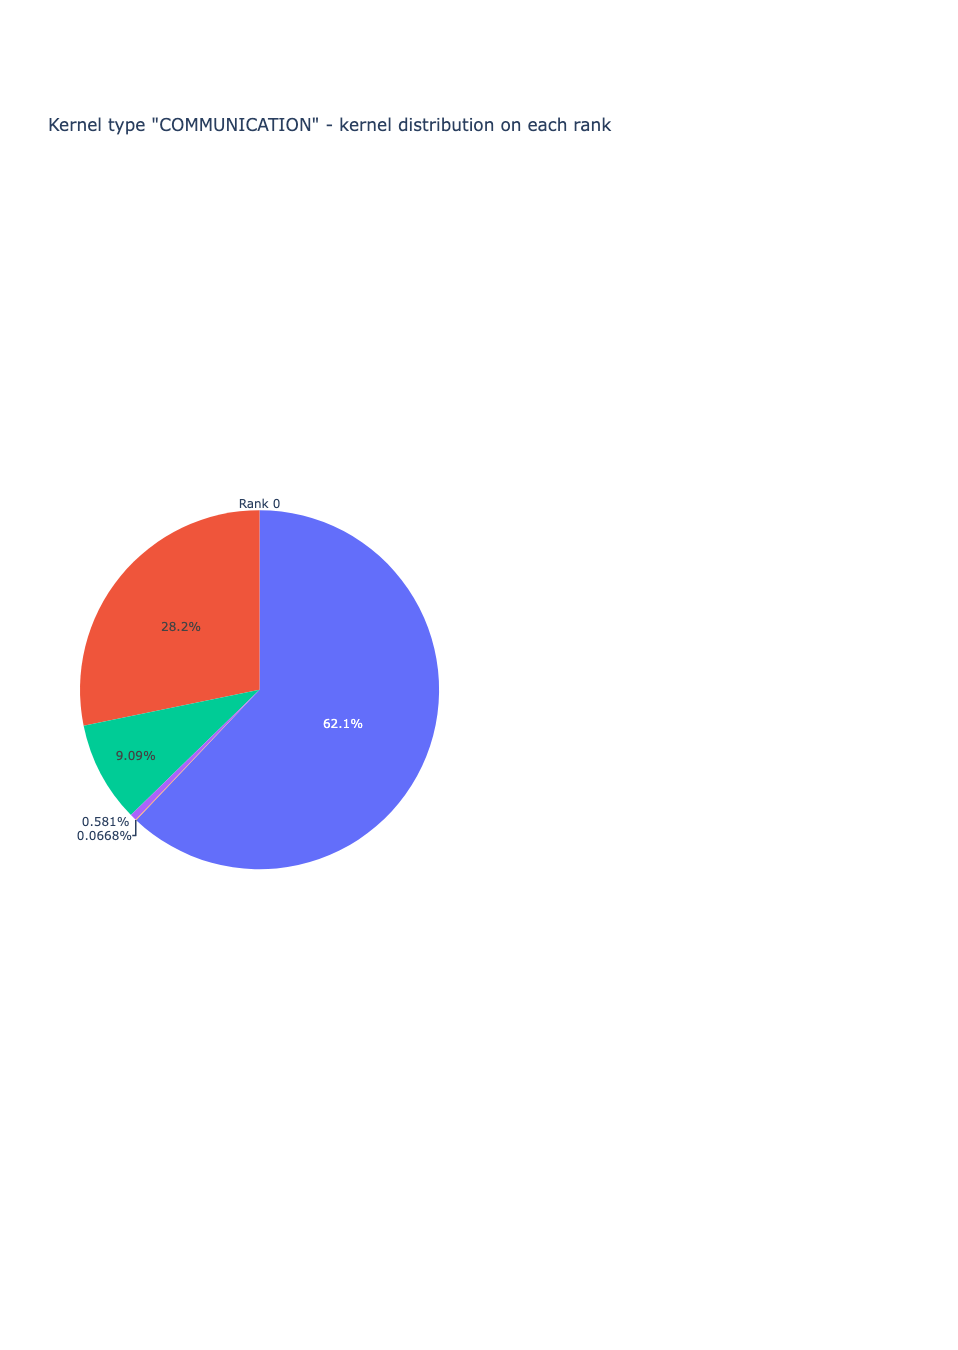

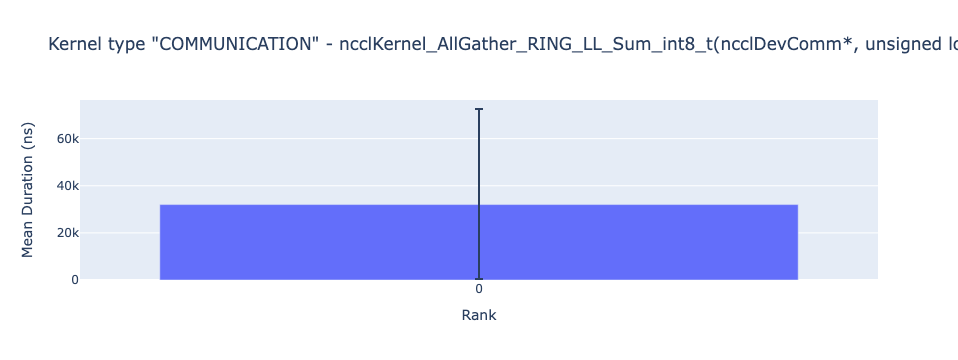

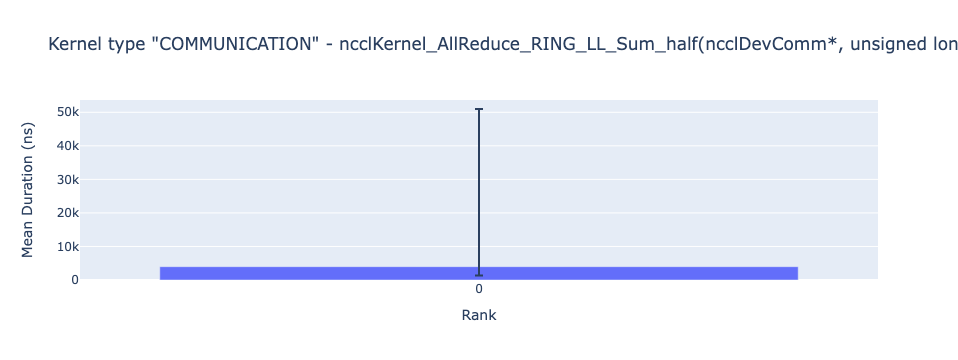

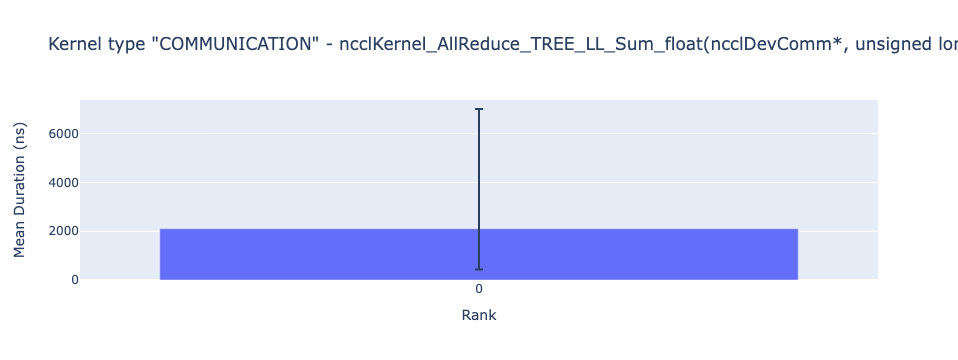

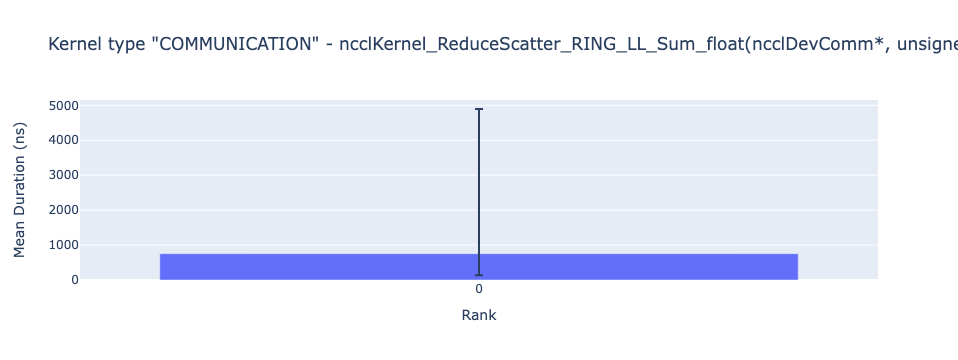

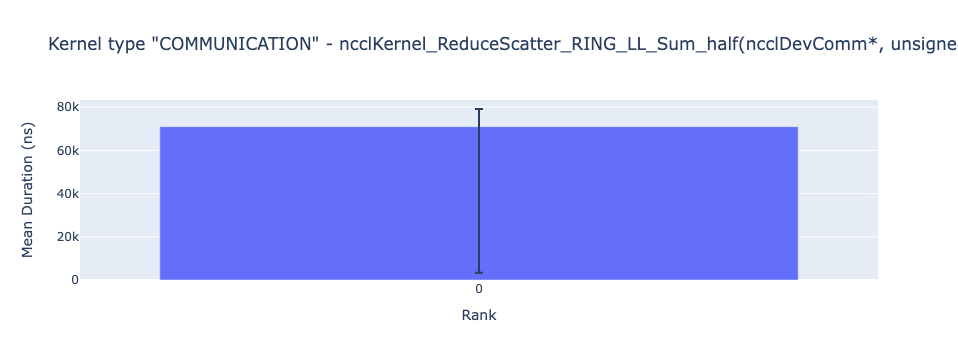

,name,time (%),time (ms),collective,experiment
0,ncclKernel_AllGather_RING_LL_Sum_int8_t(ncclDe...,46,6.8,ncclKernel_AllGather_RING_LL_Sum_int8_t,FS-Megatron
1,ncclKernel_AllReduce_RING_LL_Sum_float(ncclDev...,2,0.3,ncclKernel_AllReduce_RING_LL_Sum_float,FS-Megatron
2,ncclKernel_AllReduce_RING_LL_Sum_half(ncclDevC...,4,0.7,ncclKernel_AllReduce_RING_LL_Sum_half,FS-Megatron
4,ncclKernel_ReduceScatter_RING_LL_Sum_float(ncc...,1,0.1,ncclKernel_ReduceScatter_RING_LL_Sum_float,FS-Megatron
5,ncclKernel_ReduceScatter_RING_LL_Sum_half(nccl...,25,3.7,ncclKernel_ReduceScatter_RING_LL_Sum_half,FS-Megatron
6,ncclKernel_AllGather_RING_LL_Sum_int8_t(ncclDe...,49,7.8,ncclKernel_AllGather_RING_LL_Sum_int8_t,PTD-TP
7,ncclKernel_AllReduce_RING_LL_Sum_half(ncclDevC...,7,1.1,ncclKernel_AllReduce_RING_LL_Sum_half,PTD-TP
10,ncclKernel_ReduceScatter_RING_LL_Sum_half(nccl...,22,3.5,ncclKernel_ReduceScatter_RING_LL_Sum_half,PTD-TP


In [6]:
analyzer_test = TraceAnalysis(trace_dir = TRACE_DIR_TEST)
kernel_type_metrics_df_test, kernel_metrics_df_test = analyzer_test.get_gpu_kernel_breakdown( 
                                             num_kernels=10, 
                                             include_memory_kernels=include_memory_kernels, 
                                             image_renderer="jupyterlab")
comms_df_test = create_comms_df(kernel_metrics_df_test, TEST_TAG)
consoli_comms_df = merge_comms_df(comms_df_ctrl, comms_df_test)
consoli_comms_df

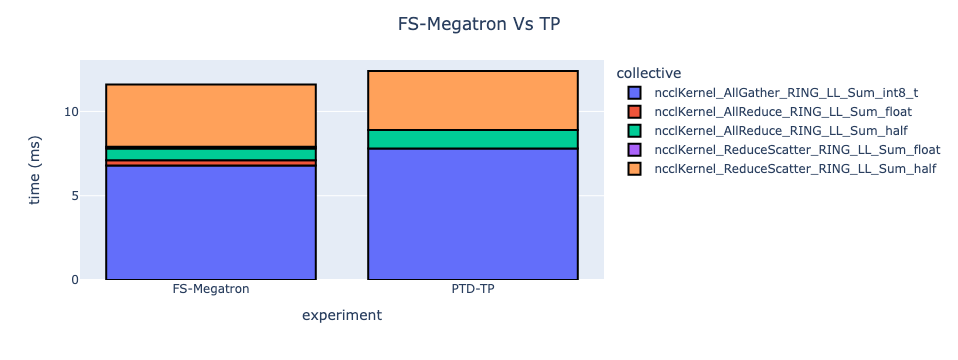

In [15]:
create_per_collective_bkdown_plot(consoli_comms_df, title = PLOT_TITLE)